## Load Libraries

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import utils
import dotenv

from nixtla import NixtlaClient 
from nixtlats import TimeGPT
from nixtlats.date_features import CountryHolidays
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

from dotenv import load_dotenv

load_dotenv()

True

## Assess if our TimeGPT token is valid

In [31]:
# nixtla_client = NixtlaClient()
# nixtla_client.validate_api_key()

## Data

In [23]:
df = pd.read_csv('data/train.csv')

store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')
# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', 'Date'], how='left')
# create unique id
df["unique_id"] = df['Store'].astype(str)+'-'+df['Dept'].astype(str)
df['Date'] = pd.to_datetime(df['Date'])
df['Weekly_Sales'] = np.where(df['Weekly_Sales'] < 0, 0, df['Weekly_Sales']) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
                "medium")) # make size a categorical variable
# rename
df.rename(columns={'Date': 'ds'}, inplace=True)
df.rename(columns={'Weekly_Sales': 'y'}, inplace=True)

cat = pd.get_dummies(df['Type'], dtype=int)
df = pd.concat([df, cat], axis=1)
df = df.drop(columns = 'Type')

cat = pd.get_dummies(df['Size'], dtype=int)
df = pd.concat([df, cat], axis=1)
df = df.drop(columns = 'Size')

df['week'] = df['ds'].dt.isocalendar().week
df['month'] = df['ds'].dt.month
df = pd.get_dummies(df, columns=['week', 'month'], dtype=int)
df=df.dropna()

unique_counts = df['unique_id'].value_counts()
filtered_unique_ids = unique_counts[unique_counts == 143].index
df = df[df['unique_id'].isin(filtered_unique_ids)]
df = df.sort_values(by=['Store', 'Dept'])
df.head(3)

,Store,Dept,ds,y,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# top_500_stores
top_500_stores = df.groupby(['unique_id']).agg({'y': 'sum'}).reset_index().sort_values(by='y', ascending=False).head(500)
df = df[df['unique_id'].isin(top_500_stores['unique_id'])]

## Plot Actuals

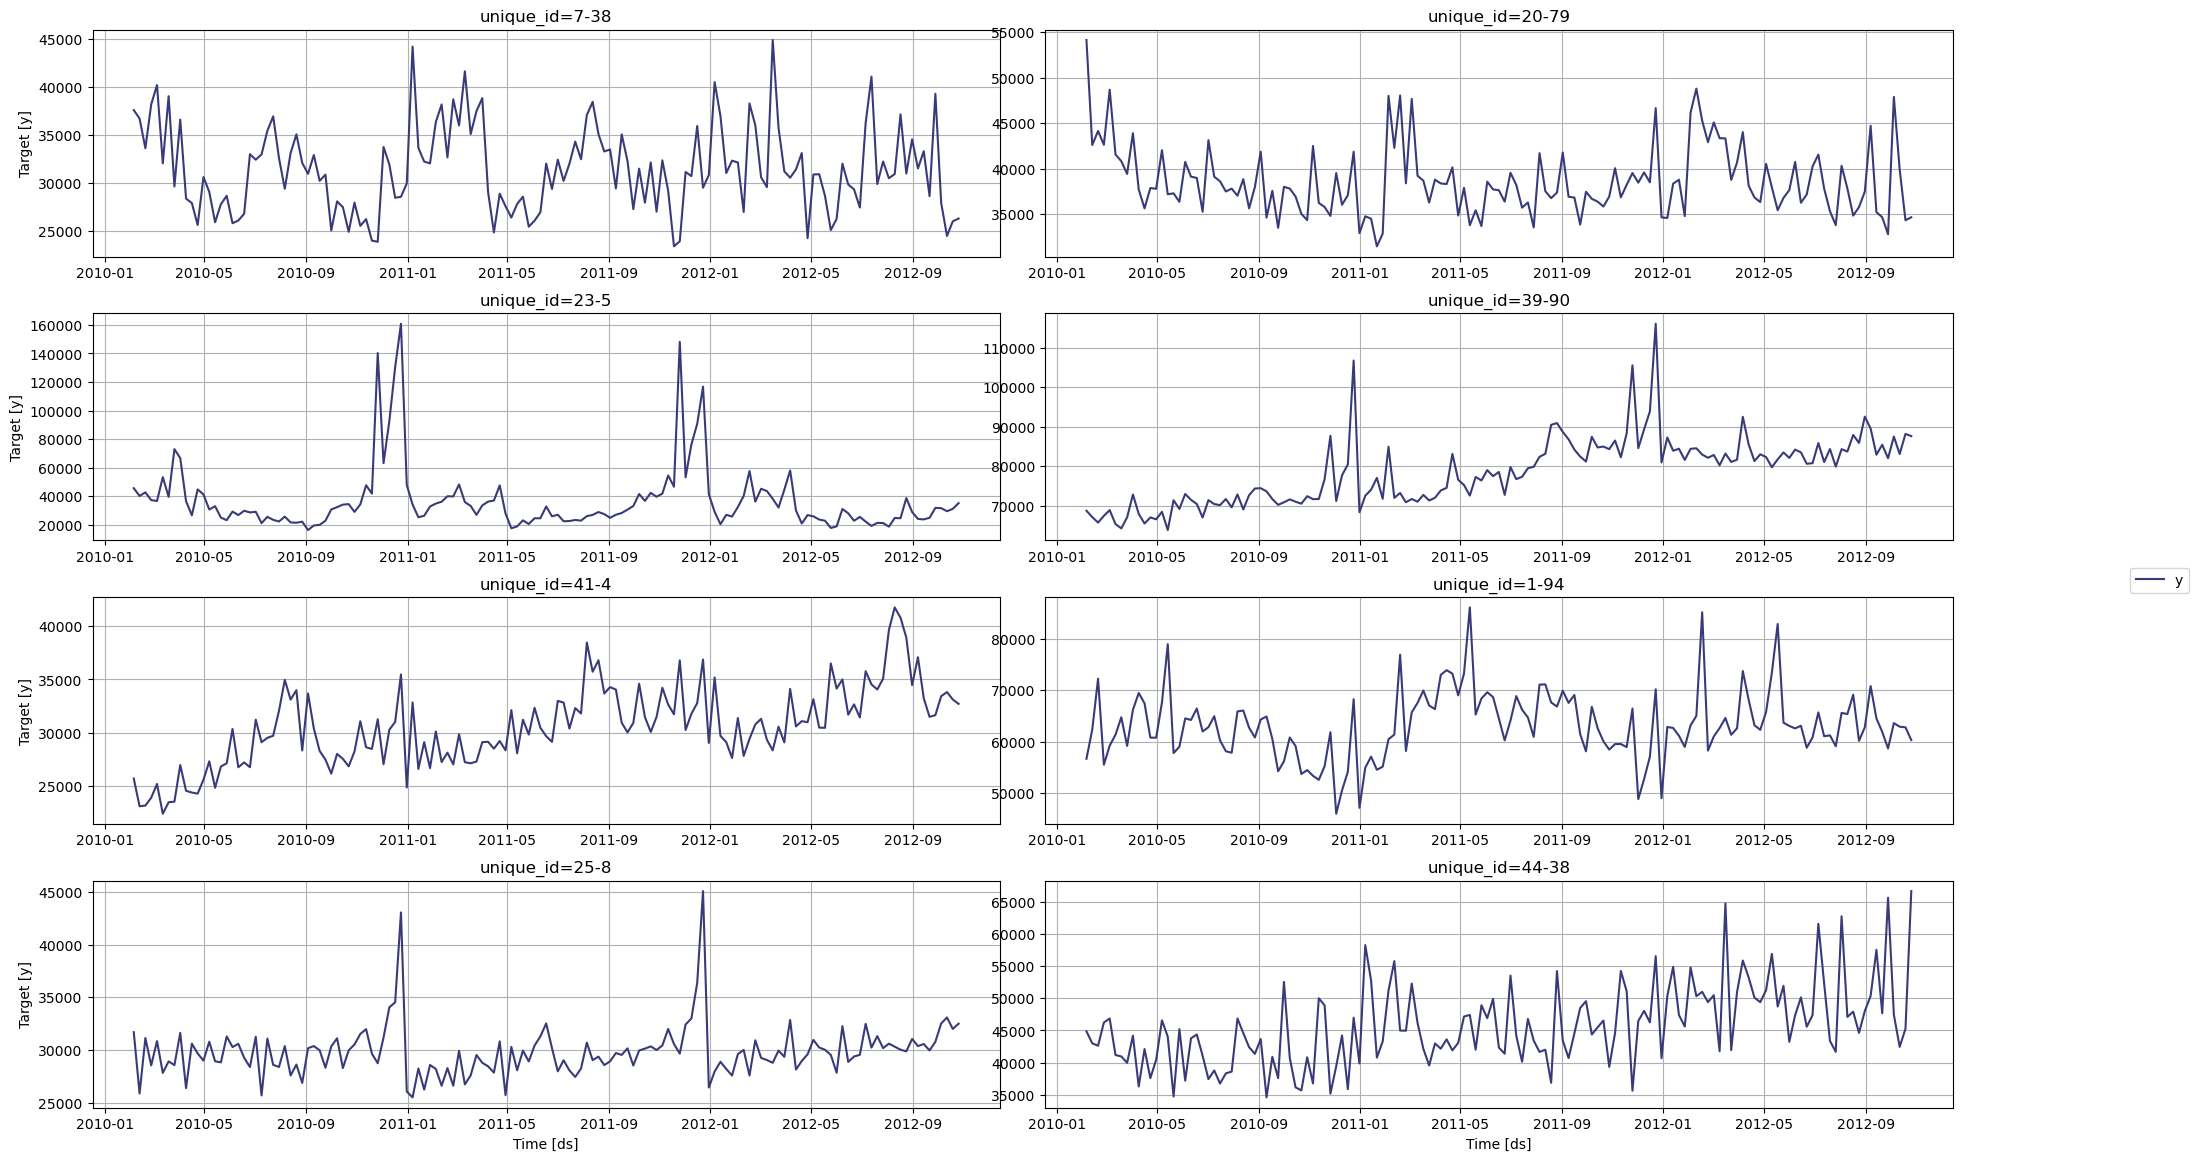

In [25]:
nixtla_client.plot(df)

## Split data between train and test

In [26]:
forecast_df = df[df['ds'] < "2012-07-06"]
holdout_df = df[(df['ds'] >= "2012-07-06") & (df['ds'] <= "2012-10-26")]
future_ex_vars_df = holdout_df.drop(columns=['y','Store', 'Dept', 'CPI', 'Unemployment'])
df_ = forecast_df.drop(columns=['Store', 'Dept', 'CPI', 'Unemployment'])
# since we have several time series not all of them have the same number of weeks in the training set
print(f"Weeks for training: {len(forecast_df['ds'].unique())} from {min(forecast_df['ds']).date()} to {max(forecast_df['ds']).date()}")
print(f"Weeks for testing: {len(holdout_df['ds'].unique())} from {min(holdout_df['ds']).date()} to {max(holdout_df['ds']).date()}")

Weeks for training: 126 from 2010-02-05 to 2012-06-29
Weeks for testing: 17 from 2012-07-06 to 2012-10-26


## Forecast

In [27]:
# %%time
timegpt_fcst_ex_vars_df = nixtla_client.forecast(
    df=df_, 
    X_df=future_ex_vars_df, 
    h=17, 
    level=[80, 90], 
    freq="W", 
    add_history=True
    )
timegpt_fcst_ex_vars_df.to_csv('forecasted_nixtla_.csv', index=False)
timegpt_fcst_ex_vars_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Using the following exogenous variables: IsHoliday, Temperature, Fuel_Price, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, A, B, C, large, medium, small, week_1, week_2, week_3, week_4, week_5, week_6, week_7, week_8, week_9, week_10, week_11, week_12, week_13, week_14, week_15, week_16, week_17, week_18, week_19, week_20, week_21, week_22, week_23, week_24, week_25, week_26, week_27, week_28, week_29, week_30, week_31, week_32, week_33, week_34, week_35, week_36, week_37, week_38, week_39, week_40, week_41, week_42, week_43, week_44, week_45, week_46, week_47, week_48, week_49, week_50, week_51, week_52, month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Histo

,unique_id,ds,TimeGPT,TimeGPT-lo-80,TimeGPT-lo-90,TimeGPT-hi-80,TimeGPT-hi-90
0,1-10,2011-04-15,31489.290030,27951.463811,26948.539237,35027.116249,36030.040824
1,1-10,2011-04-22,31258.101196,27720.274976,26717.350402,34795.927415,35798.851989
2,1-10,2011-04-29,29307.198688,25769.372469,24766.447895,32845.024907,33847.949482
3,1-10,2011-05-06,31421.108083,27883.281864,26880.357289,34958.934302,35961.858876
4,1-10,2011-05-13,28337.561541,24799.735322,23796.810748,31875.387760,32878.312335


## Plot Actuals and Forecast

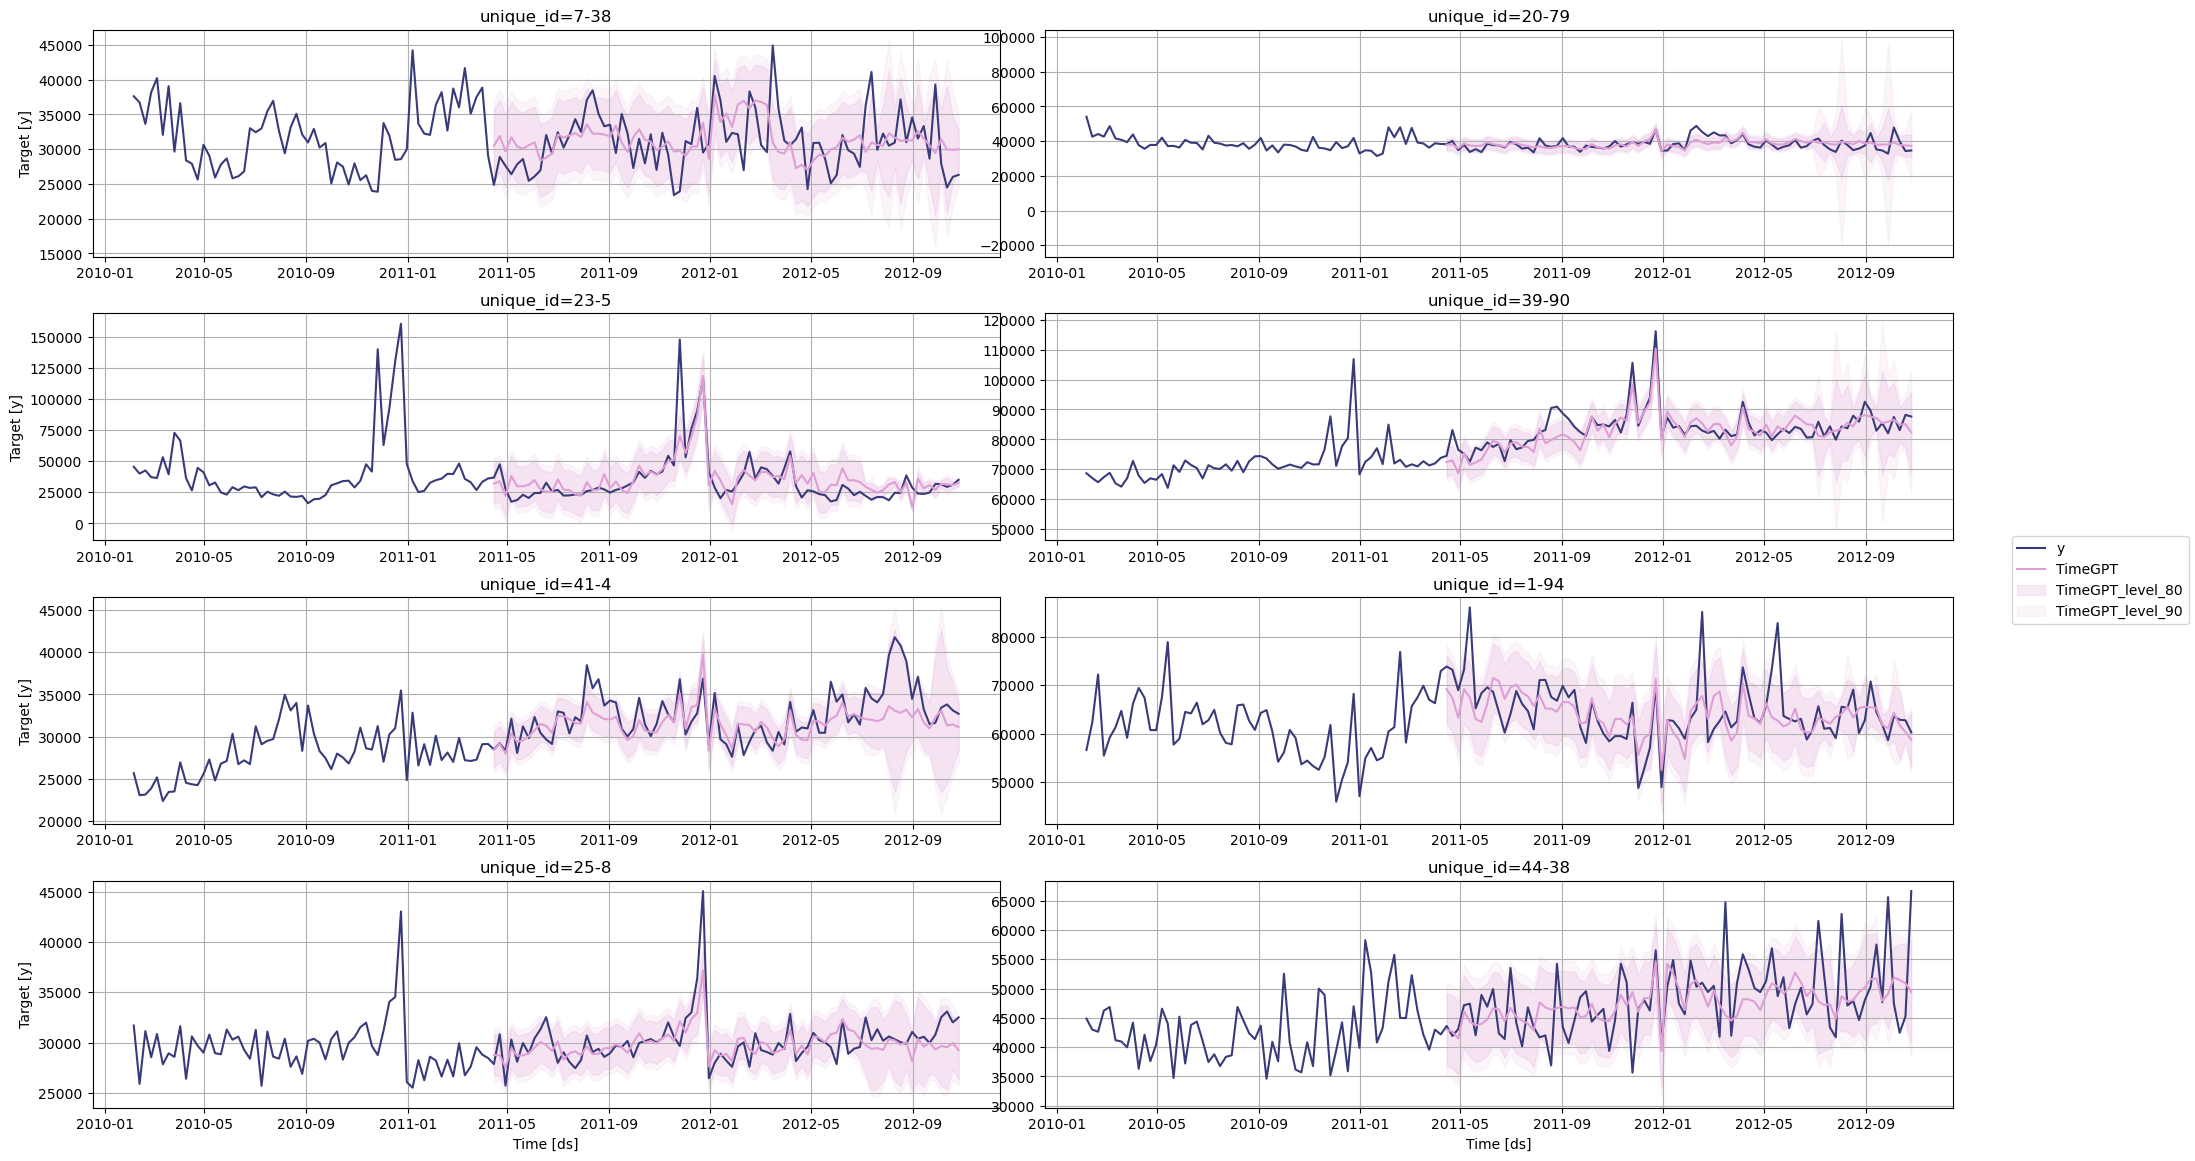

In [28]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']], 
    timegpt_fcst_ex_vars_df, 
    max_insample_length=365, 
    level=[80, 90], 
)

## Plot Importance of Exogenous Features

Text(0.5, 1.0, 'Top 10 weights')

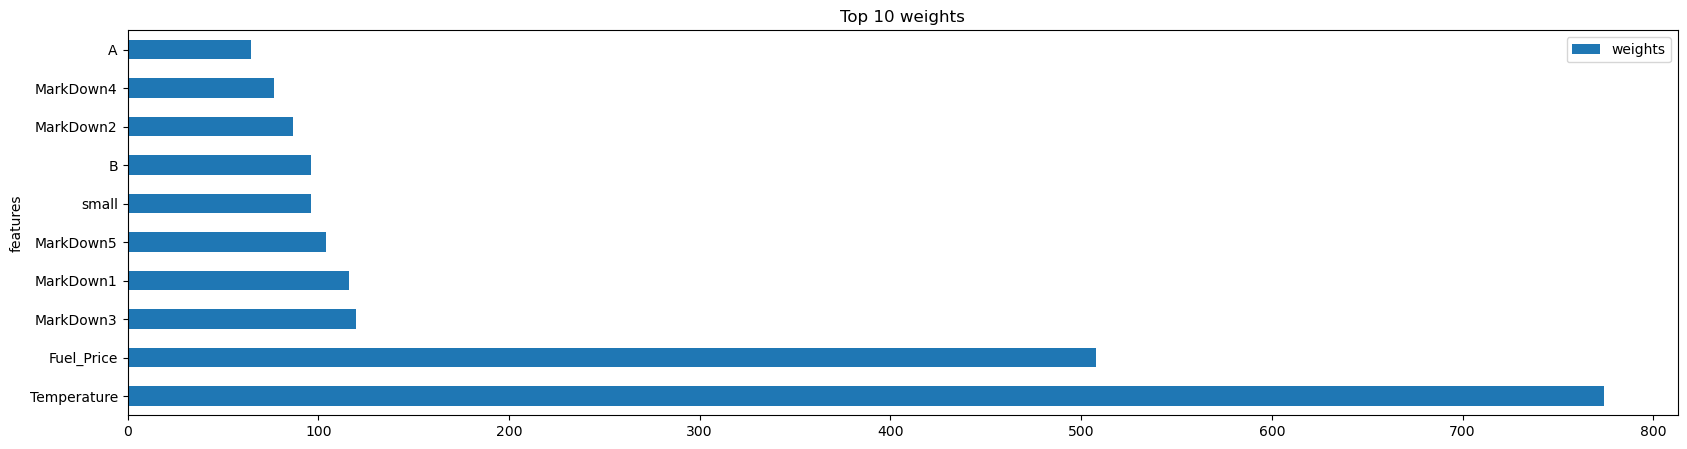

In [29]:
top_features = nixtla_client.weights_x.sort_values(by='weights', ascending=False).head(10)
top_features.plot.barh(x='features', y='weights').set_title('Top 10 weights')

## Model Evaluation

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


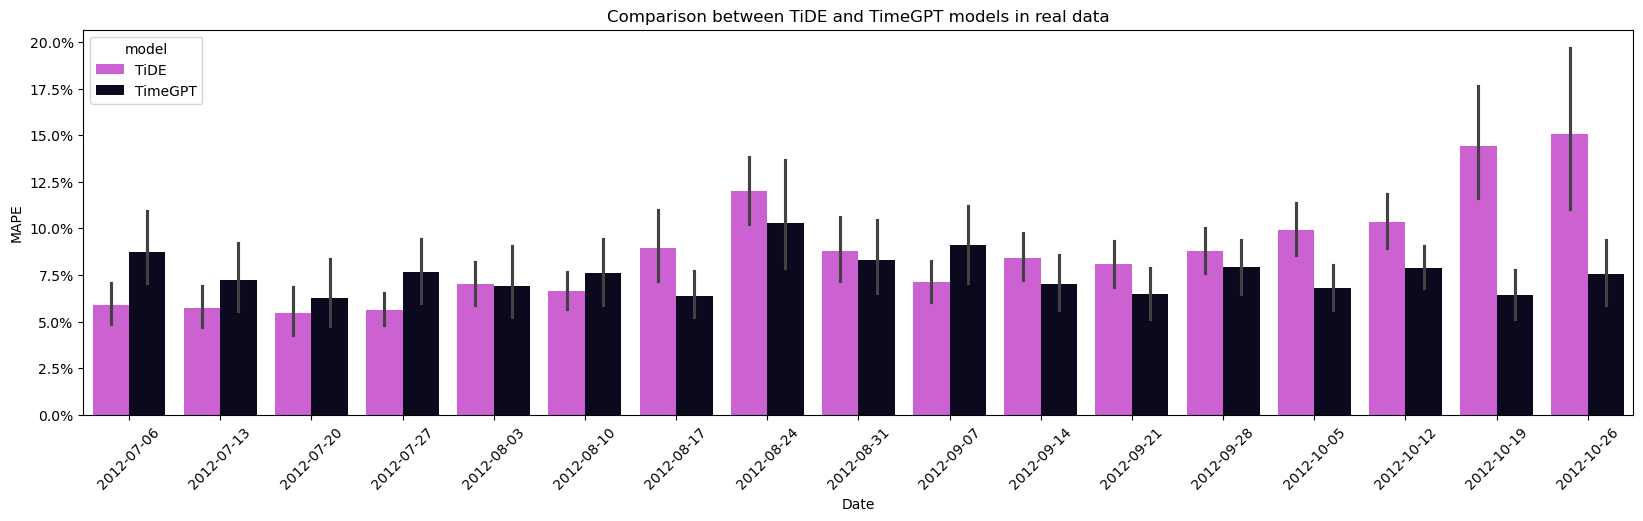

In [30]:
# load the forecast from TiDE and TimeGPT
test_ = pd.read_csv('test_.csv').dropna()
tide_model_df = pd.read_csv('tide.csv')
timegpt_fcst_ex_vars_df = pd.read_csv('forecasted_nixtla_.csv')

test_.rename(columns={'Weekly_Sales': 'target'}, inplace=True)
timegpt_fcst_ex_vars_df.rename(columns={'ds': 'Date'}, inplace=True)

# merge data frames with TiDE forecast and actuals
model_eval_df = pd.merge(test_[['unique_id', 'Date', 'target']], tide_model_df[['unique_id', 'Date', 'forecast']], on=['unique_id', 'Date'], how='inner')
model_eval_df = pd.merge(model_eval_df, timegpt_fcst_ex_vars_df[['unique_id', 'Date', 'TimeGPT']], on=['unique_id', 'Date'], how='inner')
utils.plot_model_comparison(model_eval_df)